<a href="https://colab.research.google.com/github/Suvoo/Daad-Wise-prep/blob/main/JaxQuickstart_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP training on MNIST

- init MLP and add the predict
- add data Loading in Pytorch
- add training loop, loss fn

In [1]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

1. init MLP and add the predict

In [2]:
seed = 0
mnist_img_size = (28, 28)
def init_MLP(layer_widths,parent_key,scale = 0.01):

    params = []
    keys = jax.random.split(parent_key,num = len(layer_widths) - 1)
    
    for in_width,out_width,key in zip(layer_widths[:-1],layer_widths[1:],keys):

        weight_key,bias_key = jax.random.split(key)
        print(in_width,out_width)

        params.append(
                      [ # can be done with np as well, but jax better
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784,512,256,10],key)

print(jax.tree_map(lambda x:x.shape,MLP_params))

784 512
512 256
256 10
[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [3]:
def MLP_predict(params,x):# flattend single image is X
    hidden_layers = params[:-1]
    
    activation = x
    for w,b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w,activation) + b)
    
    w_last,b_last = params[-1] #last layer doesnt have a RELu
    logits = jnp.dot(w_last,activation) + b_last
    # doesnt have cross entropy, so

    # o1 --> log(exp(o1))
    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits) 

# dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
# print(dummy_img_flat.shape)

# prediction = MLP_predict(MLP_params, dummy_img_flat)
# print(prediction.shape)

batched_MLP_predict = vmap(MLP_predict,in_axes=(None,0)) # use VMAP for jax
# small test
dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)

(16, 784)
(16, 10)


2. add data Loading in Pytorch

In [4]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))
    # flatten and then convert to Numpy

def custom_collate_fn(batch):
    # needed as torch gives tensor by default
    # print(type(batch))
    # print(type(batch[0]))
    # print(type(batch[0][0]))
    # print(type(batch[0][1]))

    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels
    
batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

# print(type(train_dataset))
# s = train_dataset[0]
# print(type(s[0]),type(s[1]))  # nparray,int
# convert PIL image (tensors) to numpy array as not pytorch, but jax

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True) # drop last is imp
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

batch_data = next(iter(train_loader))
# print(type(batch_data[0]))

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory ----> used in accuracy func
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1) # flatten by -1
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(128, 784) float32 (128,) int64


3. adding train and loss

In [5]:
num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params,imgs) # (batch_dim,10)

    return -jnp.mean(predictions * gt_lbls) # cross entropy implemntation  by multiply 1-hot encoded values

def accuracy(params,dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

    # other option:s
    # def accruracy(params,loader)
        # for img,gt_classes in loader:
        #     pred_classes = pred_classes = jnp.argmax(batched_MLP_predict(params,imgs), axis=1)
        #     acc_sum += np.sum(pred_classes == gt_classes)

        # return acc_sum/(len(loader) * 128)

@jit
def update(params,imgs,gt_lbls,lr = 0.01):
    # just find the gradients
    loss,grads = value_and_grad(loss_fn)(params,imgs,gt_lbls)

    return loss, jax.tree_map(lambda p,g: p - lr*g,params,grads)
    # jax.tree_util.tree_map()
    # jax.tree_util.tree_multimap() --> depreciated
    

MLP_params = init_MLP([784,512,256,10],key)

for epoch in range(num_epochs):

    for cnt,(imgs,lbls) in enumerate(train_loader):
        # convert labels to one hot representation
        gt_labels = jax.nn.one_hot(lbls,len(MNIST.classes))
        # print(gt_labels.shape) # batch,10
        loss,MLP_params = update(MLP_params,imgs,gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

784 512
512 256
256 10
0.23803519
0.1073034
0.06834493
0.050484367
0.039738562
0.031157559
0.020589087
0.039787382
0.03980307
0.033124156
Epoch 0, train acc = 0.9126666784286499 test acc = 0.9177999496459961
0.029177204
0.022956466
0.026860077
0.015641443
0.023880942
0.028760647
0.016483415
0.024297444
0.03352076
0.02891228
Epoch 1, train acc = 0.9342166781425476 test acc = 0.935699999332428
0.020945158
0.020697659
0.02278024
0.020431949
0.023516785
0.017985575
0.025922144
0.025104139
0.014691693
0.024138665
Epoch 2, train acc = 0.9470500349998474 test acc = 0.9451999664306641
0.01582055
0.019221058
0.01699974
0.02540654
0.02313846
0.020377321
0.011984809
0.0152841015
0.018379426
0.018689254
Epoch 3, train acc = 0.9547666907310486 test acc = 0.9502999782562256
0.018909575
0.012409797
0.029168135
0.01263524
0.0192058
0.011771373
0.012982259
0.014739108
0.020313218
0.012925497
Epoch 4, train acc = 0.9606166481971741 test acc = 0.9564999938011169


(28, 28)
pred 7
gt 7


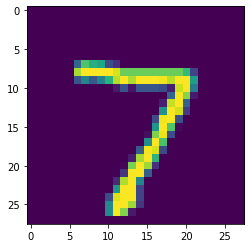

In [6]:
# fetch single image
imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size) # 784-->28
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

# Visualization
- visualize MLP Weight
- visualize embeddings using t-SNE
- dead neurons

(28, 28)


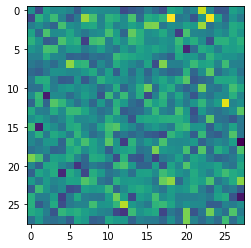

In [11]:
# visualize MLP Weight
w = MLP_params[0][0]
w.shape

w_single = w[32,:].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()


(128, 256)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


KeyError: ignored

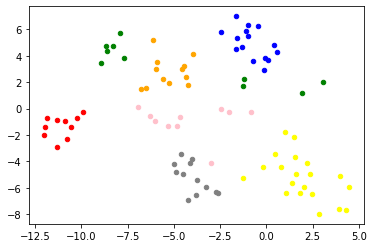

In [13]:
# todo: visualize embeddings using t-SNE

from sklearn.manifold import TSNE

def fetch_activations(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    return activation

batched_fetch_activations = vmap(fetch_activations, in_axes=(None, 0))
imgs, lbls = next(iter(test_loader))

batch_activations = batched_fetch_activations(MLP_params, imgs)
print(batch_activations.shape)  # (128, 2)

t_sne_embeddings = TSNE(n_components=2, perplexity=30,).fit_transform(batch_activations)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

for class_id in range(10):
    plt.scatter(t_sne_embeddings[lbls == class_id, 0], t_sne_embeddings[lbls == class_id, 1], s=20, color=cora_label_to_color_map[class_id])
plt.show()

In [14]:
# todo: dead neurons
# neurons which donot activate on weights
def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)
        collector.append(activation)

    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs, lbls = next(iter(test_loader))

MLP_params2 = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)  # (128, 512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))



784 512
512 256
256 10
(128, 256)
0
7
